<a href="https://colab.research.google.com/github/Alli-will/FRONT-TCCC/blob/main/Machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bibliotecas utilizadas

In [3]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#Carregamento da Base

In [4]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/Alli-will/content-datatran2024/main/datatran2024.csv',
    sep=';', encoding='latin-1', na_values='?')

print("Colunas do dataset:")
print(df.columns)

Colunas do dataset:
Index(['id', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km',
       'municipio', 'causa_acidente', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
       'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
       'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude', 'regional',
       'delegacia', 'uop'],
      dtype='object')


#Features/Target

In [5]:
# Definir alvo
target = "tipo_acidente"
y = df[target]
X = df.drop(columns=[target])

print("\nTamanho original:", len(df))


Tamanho original: 73156


#Pre Processamento

In [6]:
# 1. MANTER APENAS AS 5 MAIORES CLASSES

top5 = y.value_counts().nlargest(5).index
mask = y.isin(top5)

X = X[mask]
y = y[mask]

print("\nClasses mantidas (top 5):", list(y.unique()))
print("Novo tamanho:", len(y))


# 2. SEPARAR TIPOS DE VARIÁVEIS

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print("\nNuméricas:", list(numeric_cols))
print("Categóricas:", list(categorical_cols))

# 3. TRANSFORMADOR

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)



Classes mantidas (top 5): ['Saída de leito carroçável', 'Colisão traseira', 'Tombamento', 'Colisão lateral mesmo sentido', 'Colisão transversal']
Novo tamanho: 48516

Numéricas: ['id', 'br', 'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos', 'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude']
Categóricas: ['data_inversa', 'dia_semana', 'horario', 'uf', 'km', 'municipio', 'causa_acidente', 'classificacao_acidente', 'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'regional', 'delegacia', 'uop']


#Modelos

In [7]:
rf = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)

gb = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42
)


rf_pipeline = Pipeline([("preprocess", preprocess),
                       ("model", rf)])

gb_pipeline = Pipeline([("preprocess", preprocess),
                       ("model", gb)])

#Validaçao Cruzada (3 Folds)

In [8]:


kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cv_rf = cross_validate(
    rf_pipeline,
    X, y,
    cv=kf,
    scoring=['accuracy', 'f1_macro'],
    n_jobs=-1
)

cv_gb = cross_validate(
    gb_pipeline,
    X, y,
    cv=kf,
    scoring=['accuracy', 'f1_macro'],
    n_jobs=-1
)


# Resultados


In [9]:
print("\n===== RESULTADOS =====")
print("RANDOM FOREST")
print(f"Accuracy:  {cv_rf['test_accuracy'].mean():.4f}")
print(f"F1-Macro: {cv_rf['test_f1_macro'].mean():.4f}")

print("\nGRADIENT BOOSTING")
print(f"Accuracy:  {cv_gb['test_accuracy'].mean():.4f}")
print(f"F1-Macro: {cv_gb['test_f1_macro'].mean():.4f}")

print("\nFinalizado com sucesso ✔")



===== RESULTADOS =====
RANDOM FOREST
Accuracy:  0.7080
F1-Macro: 0.6729

GRADIENT BOOSTING
Accuracy:  0.7217
F1-Macro: 0.6946

Finalizado com sucesso ✔


# INDICADORES ADICIONAIS

In [10]:
def print_stats(name, cv_results):
    acc = cv_results['test_accuracy']
    f1 = cv_results['test_f1_macro']

    print(f"\n=== {name} - Estatísticas detalhadas ===")
    print("Acurácia por fold:", np.round(acc, 4))
    print("F1-Macro por fold:", np.round(f1, 4))

    print(f"Acurácia média: {acc.mean():.4f}")
    print(f"Acurácia desvio padrão: {acc.std():.4f}")

    print(f"F1-Macro média: {f1.mean():.4f}")
    print(f"F1-Macro desvio padrão: {f1.std():.4f}")


print_stats("Random Forest", cv_rf)
print_stats("Gradient Boosting", cv_gb)



=== Random Forest - Estatísticas detalhadas ===
Acurácia por fold: [0.7058 0.7088 0.7096]
F1-Macro por fold: [0.6711 0.6739 0.6738]
Acurácia média: 0.7080
Acurácia desvio padrão: 0.0016
F1-Macro média: 0.6729
F1-Macro desvio padrão: 0.0013

=== Gradient Boosting - Estatísticas detalhadas ===
Acurácia por fold: [0.7209 0.7217 0.7225]
F1-Macro por fold: [0.6932 0.6951 0.6954]
Acurácia média: 0.7217
Acurácia desvio padrão: 0.0007
F1-Macro média: 0.6946
F1-Macro desvio padrão: 0.0010


IMPORTÂNCIA DAS FEATURES (RANDOM FOREST)

In [11]:
print("\n===== IMPORTÂNCIA DAS FEATURES (RANDOM FOREST) =====")

start_time = time.time()

# 1) Ajusta o preprocessador para gerar nomes das colunas
preprocess.fit(X)

# Nomes das features numéricas
num_features = numeric_cols

# Nomes das features categóricas após OneHot
cat_features = preprocess.named_transformers_["cat"].get_feature_names_out(categorical_cols)

# Junta todas as features transformadas
all_features = np.concatenate([num_features, cat_features])

# 2) Treina RandomForest menor apenas para extrair importância das features
rf_for_importance = RandomForestClassifier(
    n_estimators=50,         # menos árvores, mais rápido
    max_features="sqrt",     # reduz custo por árvore
    random_state=42,
    n_jobs=-1
)

# Transformar X uma vez só
X_transformed = preprocess.transform(X)

# Treinar
rf_for_importance.fit(X_transformed, y)

# 3) Obtém as importâncias das features
importances = rf_for_importance.feature_importances_

# 4) Organiza em um DataFrame ordenado
df_importance = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Mostra as 20 principais
print(df_importance.head(20))

print(f"\nImportância das features calculada com sucesso ✔")
print(f"Tempo total: {time.time() - start_time:.2f}s")



===== IMPORTÂNCIA DAS FEATURES (RANDOM FOREST) =====
                                                 Feature  Importance
9                                               veiculos    0.069891
6                                                 ilesos    0.033245
2                                                pessoas    0.030312
10278  causa_acidente_Acessar a via sem observar a pr...    0.025018
11                                             longitude    0.023101
10                                              latitude    0.021232
10292  causa_acidente_Condutor deixou de manter distâ...    0.020626
0                                                     id    0.020171
10317         causa_acidente_Manobra de mudança de faixa    0.012907
1                                                     br    0.011780
10938                                       uso_solo_Não    0.011453
10303  causa_acidente_Desrespeitar a preferência no c...    0.009879
10369                                 tipo_pista_

TOP 20 FEATURES (RANDOM FOREST)

/tmp/ipython-input-1168331142.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


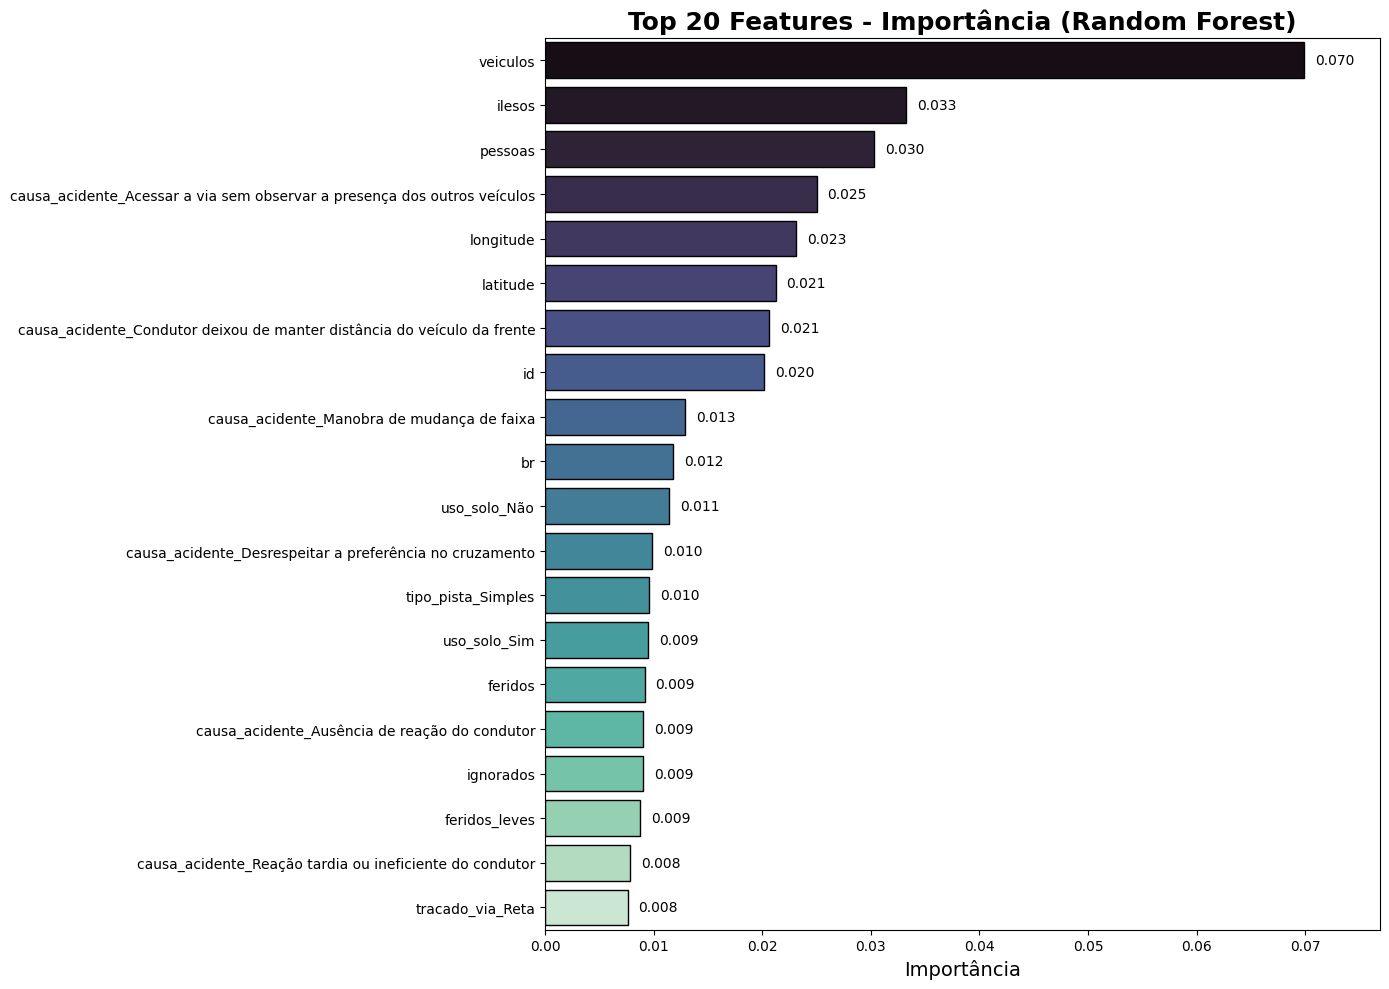

In [12]:
top20 = df_importance.head(20)

plt.figure(figsize=(14,10))

# Barplot horizontal com gradiente

bars = sns.barplot(
x="Importance",
y="Feature",
data=top20,
palette=sns.color_palette("mako", n_colors=20),
edgecolor="k"
)

# Anotando valores na barra

for bar in bars.patches:
    width = bar.get_width()
    plt.text(
        width + 0.001,
        bar.get_y() + bar.get_height()/2,
        f"{width:.3f}",
        va='center',
        fontsize=10
    )

plt.title("Top 20 Features - Importância (Random Forest)", fontsize=18, weight='bold')
plt.xlabel("Importância", fontsize=14)
plt.ylabel("")
plt.xlim(right=top20['Importance'].max() * 1.1) # Ajusta o limite do eixo X
plt.tight_layout()
plt.show()

MATRIZ DE CONFUSÃO (RANDOM FOREST)

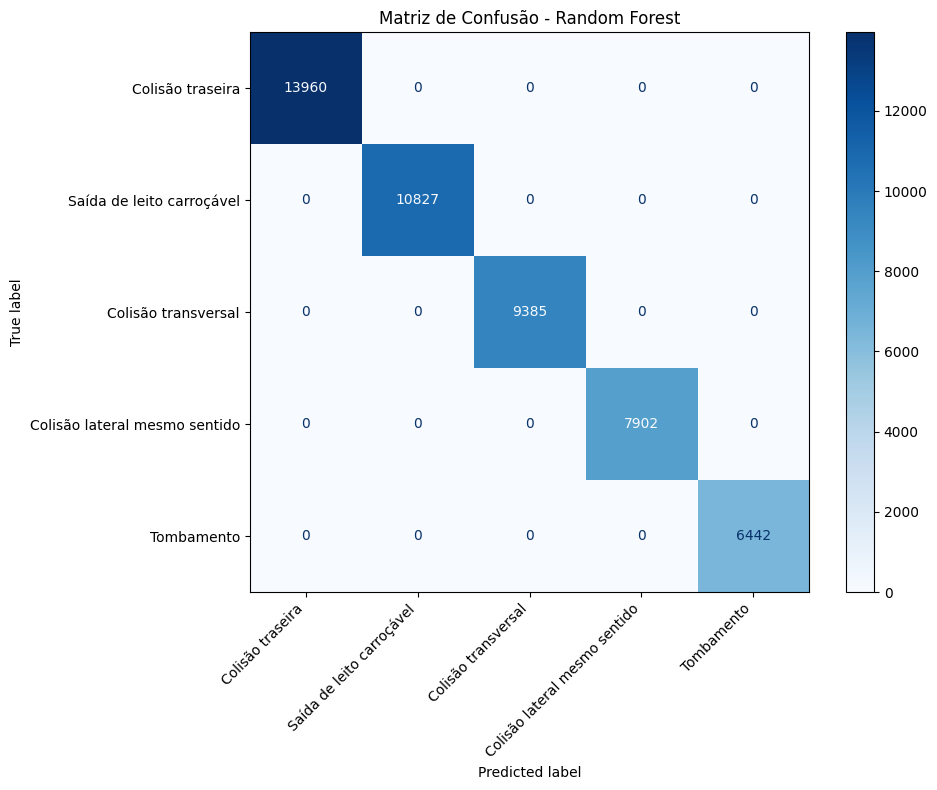

In [13]:
rf_pipeline.fit(X, y) # Treina o modelo completo
y_pred_rf = rf_pipeline.predict(X)

cm_rf = confusion_matrix(y, y_pred_rf, labels=top5)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=top5)

plt.figure(figsize=(10,8))
disp_rf.plot(cmap='Blues', values_format='d', ax=plt.gca())

plt.title("Matriz de Confusão - Random Forest")

plt.xticks(rotation=45, ha='right')

plt.tight_layout() # Ajusta layout para caber tudo
plt.show()

IMPORTÂNCIA DAS FEATURES (GRADIENT BOOSTING)

In [14]:
print("\n===== IMPORTÂNCIA DAS FEATURES (GRADIENT BOOSTING) =====")

# Treina Gradient Boosting com número menor de árvores para agilizar

gb_for_importance = GradientBoostingClassifier(
n_estimators=50,  # reduz custo
max_features="sqrt",
random_state=42
)

# Transformar X uma vez

X_transformed = preprocess.transform(X)

# Treinar

gb_for_importance.fit(X_transformed, y)

# Obter importâncias

importances_gb = gb_for_importance.feature_importances_

# Organizar DataFrame

df_importance_gb = pd.DataFrame({
"Feature": np.concatenate([numeric_cols, preprocess.named_transformers_["cat"].get_feature_names_out(categorical_cols)]),
"Importance": importances_gb
}).sort_values(by="Importance", ascending=False)

# Mostrar top 20

top20_gb = df_importance_gb.head(20)
print(top20_gb)




===== IMPORTÂNCIA DAS FEATURES (GRADIENT BOOSTING) =====
                                                 Feature  Importance
9                                               veiculos    0.184182
6                                                 ilesos    0.129508
10317         causa_acidente_Manobra de mudança de faixa    0.081065
2                                                pessoas    0.071609
10292  causa_acidente_Condutor deixou de manter distâ...    0.069984
10938                                       uso_solo_Não    0.033622
10939                                       uso_solo_Sim    0.029250
10278  causa_acidente_Acessar a via sem observar a pr...    0.022941
10329  causa_acidente_Reação tardia ou ineficiente do...    0.019350
10303  causa_acidente_Desrespeitar a preferência no c...    0.016069
10357                       condicao_metereologica_Chuva    0.014623
10288  causa_acidente_Avarias e/ou desgaste excessivo...    0.012630
10420                                  tracad

TOP 20 FEATURES (GRADIENT BOOSTING)

/tmp/ipython-input-834930600.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


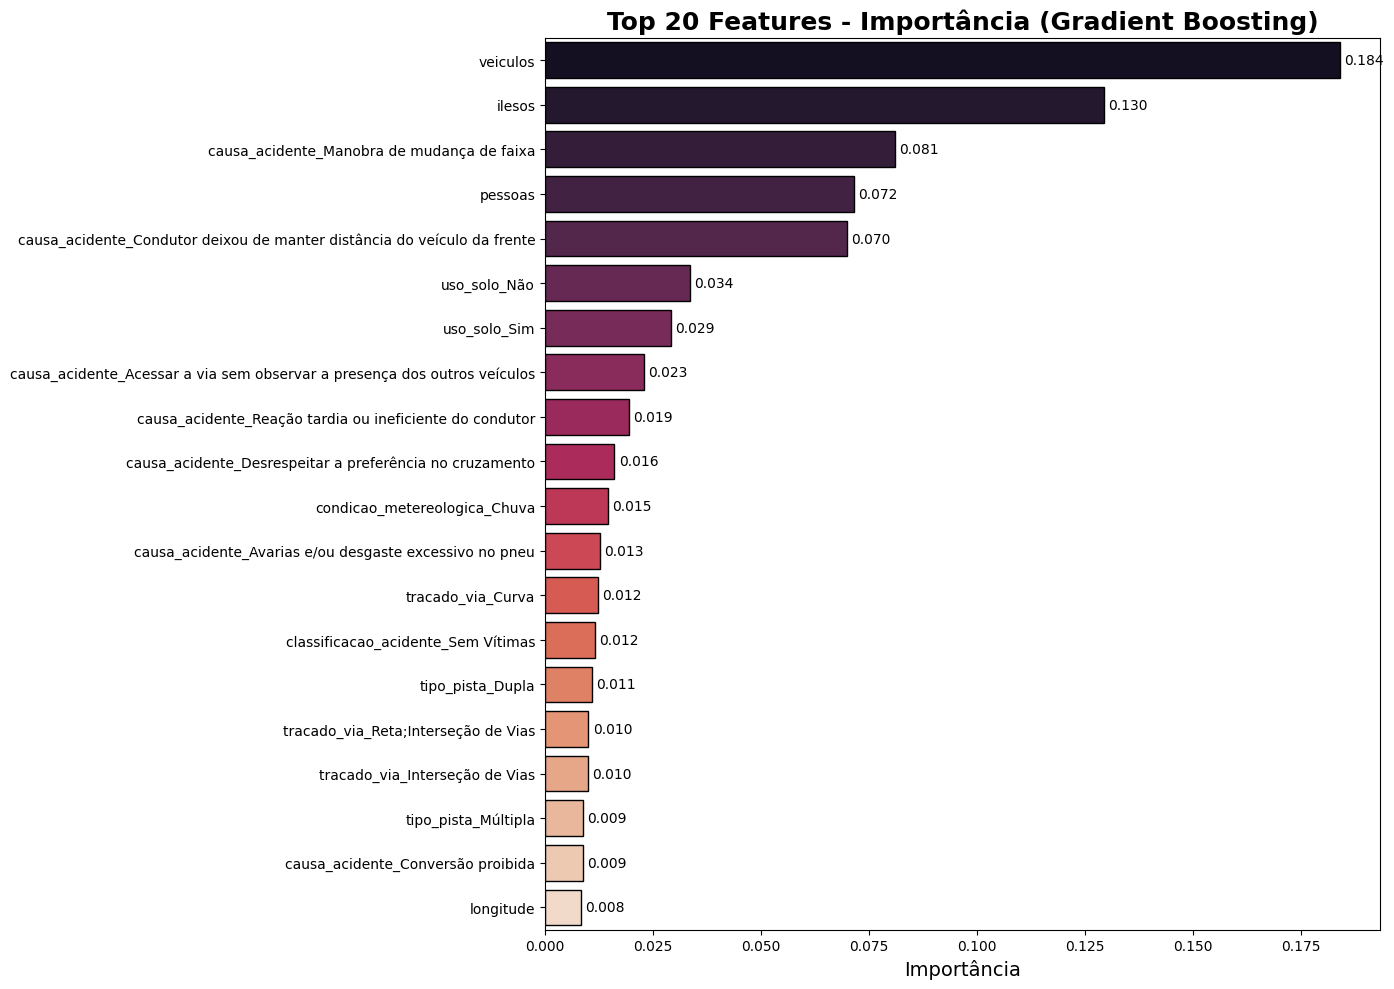

In [15]:
plt.figure(figsize=(14,10))
bars = sns.barplot(
x="Importance",
y="Feature",
data=top20_gb,
palette=sns.color_palette("rocket", n_colors=20),
edgecolor="k"
)

for bar in bars.patches:
    width = bar.get_width()
    plt.text(
        width + 0.001,
        bar.get_y() + bar.get_height()/2,
        f"{width:.3f}",
        va='center',
        fontsize=10
    )

plt.title("Top 20 Features - Importância (Gradient Boosting)", fontsize=18, weight='bold')
plt.xlabel("Importância", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.show()

In [ ]:
MATRIZ CONFUSÃO (GRADIENT BOOSTING)

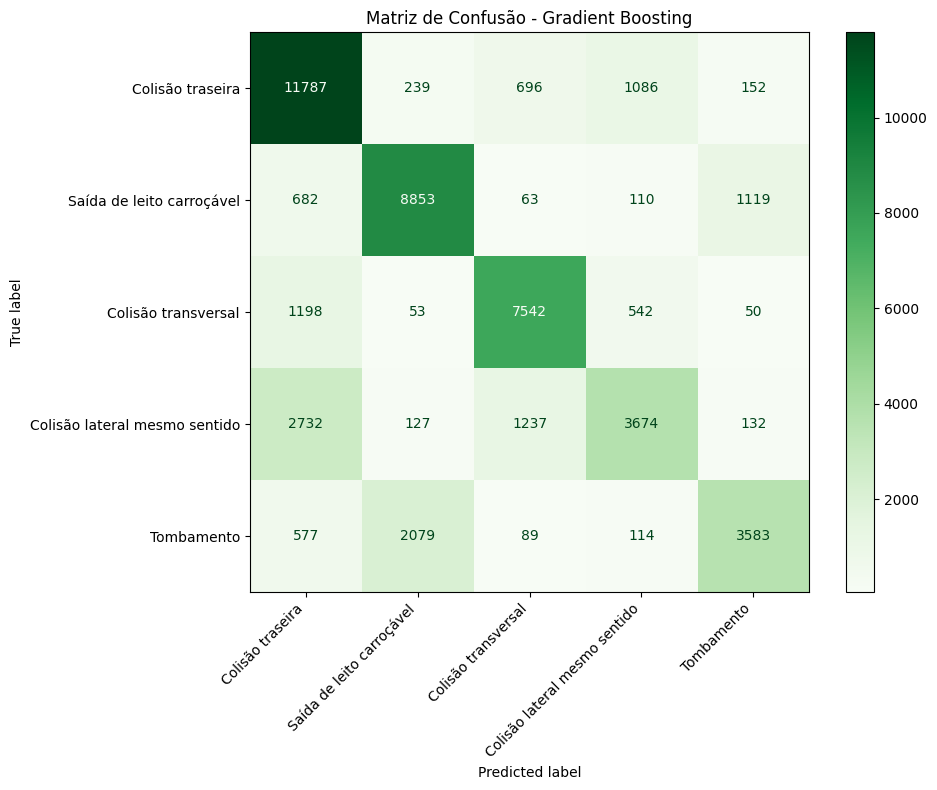

In [16]:
gb_pipeline.fit(X, y) # Treina o modelo completo
y_pred_gb = gb_pipeline.predict(X)

cm_gb = confusion_matrix(y, y_pred_gb, labels=top5)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=top5)

plt.figure(figsize=(10,8))
disp_gb.plot(cmap='Greens', values_format='d', ax=plt.gca())
plt.title("Matriz de Confusão - Gradient Boosting")
plt.xticks(rotation=45, ha='right')

plt.tight_layout() # Ajusta layout para caber tudo

plt.show()